In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D
import tensorflow
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras import Model
#!pip install keras_tuner
#!pip install datasets
import keras_tuner
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
"""
import sys
!{sys.executable} -m pip install datasets"""

'\nimport sys\n!{sys.executable} -m pip install datasets'

In [3]:
RTdata = tfds.load('huggingface:rotten_tomatoes')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-10 13:53:11.525658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-10 13:53:11.525785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
RTdata

{'train': <PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 'validation': <PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 'test': <PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>}

In [5]:
df_train = pd.DataFrame(RTdata['train'])
df_vali = pd.DataFrame(RTdata['validation'])
df_test = pd.DataFrame(RTdata['test'])

2023-06-10 13:53:11.650117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
#Tensors into arrays
for i in range(len(df_train['label'])):
    df_train['label'].iloc[i] = df_train['label'].iloc[i].numpy()
    df_train['text'].iloc[i] = df_train['text'].iloc[i].numpy().decode()

for i in range(len(df_vali['label'])):
    df_vali['label'].iloc[i] = df_vali['label'].iloc[i].numpy()
    df_vali['text'].iloc[i] = df_vali['text'].iloc[i].numpy().decode()

for i in range(len(df_test['label'])):
    df_test['label'].iloc[i] = df_test['label'].iloc[i].numpy()
    df_test['text'].iloc[i] = df_test['text'].iloc[i].numpy().decode()

In [7]:
df_train.to_csv('../Project/rotten_tomatoes_train.csv')
df_vali.to_csv('../Project/rotten_tomatoes_validation.csv')
df_test.to_csv('../Project/rotten_tomatoes_test.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8530 entries, 0 to 8529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8530 non-null   object
 1   text    8530 non-null   object
dtypes: object(2)
memory usage: 133.4+ KB


In [9]:
df_vali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1066 non-null   object
 1   text    1066 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1066 non-null   object
 1   text    1066 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


In [11]:
df_train.label.value_counts()

1    4265
0    4265
Name: label, dtype: int64

In [12]:
df_test.label.value_counts()

1    533
0    533
Name: label, dtype: int64

In [13]:
x_train, y_train = df_train['text'].to_numpy(), df_train['label'].to_numpy().astype('int')
x_vali, y_vali = df_vali['text'].to_numpy(), df_vali['label'].to_numpy().astype('int')
x_test, y_test = df_test['text'].to_numpy(), df_test['label'].to_numpy().astype('int')

In [14]:
#Training Set
print('Training Set Size:', x_train.shape, y_train.shape)
#Validation Set
print('Validation Set Size:', x_vali.shape, y_vali.shape)
#Test Set
print('Test Set Size:', x_test.shape, y_test.shape)

Training Set Size: (8530,) (8530,)
Validation Set Size: (1066,) (1066,)
Test Set Size: (1066,) (1066,)


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocabSize = 10000
tokenizer = Tokenizer(num_words=vocabSize, oov_token=None)
tokenizer.fit_on_texts(x_train)
print('Document Size:', tokenizer.document_count)
print('Word Size:', tokenizer.num_words)

Document Size: 8530
Word Size: 10000


In [16]:
tokenizer.word_counts

OrderedDict([('if', 422),
             ('you', 716),
             ('come', 80),
             ('from', 544),
             ('a', 5897),
             ('family', 90),
             ('that', 1976),
             ('eats', 1),
             ('meddles', 1),
             ('argues', 1),
             ('laughs', 60),
             ('kibbitzes', 1),
             ('and', 4971),
             ('fights', 6),
             ('together', 64),
             ('then', 85),
             ('go', 92),
             ('see', 151),
             ('this', 1186),
             ('delightful', 23),
             ('comedy', 299),
             ('gorgeous', 23),
             ('witty', 29),
             ('seductive', 5),
             ('movie', 1067),
             ('eric', 8),
             ('schweig', 2),
             ('graham', 3),
             ('greene', 2),
             ('both', 127),
             ('exude', 3),
             ('an', 1067),
             ('air', 27),
             ('of', 4885),
             ('dignity', 7),
            

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
seq_len = None
def preProcessing (text_arr):
    sequence = tokenizer.texts_to_sequences(text_arr)
    padded = pad_sequences(sequence, maxlen=seq_len, padding='post', truncating='post')
    return sequence, padded

train_sequence, train_padded = preProcessing(x_train)
vali_sequence, vali_padded = preProcessing(x_vali)
test_sequence, test_padded = preProcessing(x_test)

In [18]:
tensorflow.keras.backend.clear_session()

In [98]:
def LSTM_RT(hp_RT_LSTM):
  hp_units1 = hp_RT_LSTM.Int("units1", min_value=64, max_value=196, step=8)
  hp_units2 = hp_RT_LSTM.Int("units2", min_value=64, max_value=156, step=8)
  hp_units3 = hp_RT_LSTM.Float("units3", min_value=0.2, max_value=0.6, step=0.1)
  hp_units4 = hp_RT_LSTM.Float("units4", min_value=0.7, max_value=0.95, step=0.05)
    
  model_LSTM_v3 = Sequential()
  model_LSTM_v3.add(Embedding(input_dim = vocabSize, output_dim = hp_units1, input_length = seq_len)) #,kernel_regularizer=L2(0.01)
  model_LSTM_v3.add(Dropout(hp_units3))
  model_LSTM_v3.add(LSTM(hp_units2))
  model_LSTM_v3.add(Dropout(hp_units4))
  model_LSTM_v3.add(Dense(1, activation='sigmoid'))
  model_LSTM_v3.compile(loss=BinaryCrossentropy(from_logits=False),optimizer=Adam(), metrics=[binary_accuracy])
  model_LSTM_v3.save('../content/model/RT_LSTM.h5')
  #model_SA_LSTM.summary()
  return model_LSTM_v3

In [99]:
hp_RT_LSTM = keras_tuner.HyperParameters()
LSTM_RT(hp_RT_LSTM)
tuner = keras_tuner.RandomSearch(LSTM_RT, objective = 'val_binary_accuracy', max_trials = 10, executions_per_trial = 1)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 196, 'step': 8, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 156, 'step': 8, 'sampling': None}
units3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': None}
units4 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.95, 'step': 0.05, 'sampling': None}


In [100]:
batch=128
tuner.search(train_padded, y_train, epochs=15, batch_size = batch, validation_data=(test_padded, y_test))

Trial 10 Complete [00h 06m 53s]
val_binary_accuracy: 0.7682926654815674

Best val_binary_accuracy So Far: 0.7804877758026123
Total elapsed time: 00h 22m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [101]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 112
units2: 152
units3: 0.30000000000000004
units4: 0.8
Score: 0.7804877758026123
Trial summary
Hyperparameters:
units1: 144
units2: 80
units3: 0.30000000000000004
units4: 0.9000000000000001
Score: 0.7748593091964722
Trial summary
Hyperparameters:
units1: 96
units2: 72
units3: 0.4000000000000001
units4: 0.9500000000000002
Score: 0.7739211916923523
Trial summary
Hyperparameters:
units1: 104
units2: 128
units3: 0.2
units4: 0.8500000000000001
Score: 0.7739211916923523
Trial summary
Hyperparameters:
units1: 72
units2: 144
units3: 0.4000000000000001
units4: 0.8
Score: 0.7711069583892822
Trial summary
Hyperparameters:
units1: 136
units2: 104
units3: 0.4000000000000001
units4: 0.9000000000000001
Score: 0.7692307829856873
Trial summary
Hyperparameters:
units1: 120
units2: 128
units3: 0.2
units4: 0.8
Score: 0.7682926654815674
Trial summary
Hyperparameters:
units1: 160
units2: 136
units3: 

In [102]:
tensorflow.keras.backend.clear_session()
model_LSTM_best_model = Sequential()
model_LSTM_best_model.add(Embedding(input_dim = vocabSize, output_dim = 112, input_length = seq_len))  
model_LSTM_best_model.add(Dropout(0.3))
model_LSTM_best_model.add(LSTM(152)) 
model_LSTM_best_model.add(Dropout(0.8))
model_LSTM_best_model.add(Dense(1, activation='sigmoid'))
model_LSTM_best_model.compile(loss=BinaryCrossentropy(from_logits=False),optimizer=Adam(), metrics=[binary_accuracy])
model_LSTM_best_model.save('../content/model/RT_LSTM_hyperparams.h5')
model_LSTM_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 112)         1120000   
                                                                 
 dropout (Dropout)           (None, None, 112)         0         
                                                                 
 lstm (LSTM)                 (None, 152)               161120    
                                                                 
 dropout_1 (Dropout)         (None, 152)               0         
                                                                 
 dense (Dense)               (None, 1)                 153       
                                                                 
Total params: 1,281,273
Trainable params: 1,281,273
Non-trainable params: 0
_________________________________________________________________


In [103]:
batch = 128
metric = 'val_binary_accuracy'
callback = ModelCheckpoint(filepath=r"../Project/checkpoints/{}".format('RT_LSTM_hyperparams'), monitor=metric,
                    verbose=2, save_best_only=True, mode='max')
history_LSTM_hyperparams = model_LSTM_best_model.fit(train_padded, y_train, batch_size=batch, epochs=30, validation_data=(vali_padded, y_vali), callbacks=callback)#validation_data=(x_vali_gen, y_vali_gen)) ,batch_size=batch,

Epoch 1/30


2023-06-10 01:51:18.267010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 01:51:54.972576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 01:52:10.536113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6953 - binary_accuracy: 0.4961

2023-06-10 01:53:09.087869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 01:53:11.927011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.50000, saving model to ../Project/checkpoints/RT_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 125s 959ms/step - loss: 0.6953 - binary_accuracy: 0.4961 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.6945 - binary_accuracy: 0.4996
Epoch 2: val_binary_accuracy did not improve from 0.50000
67/67 [==============================] - 39s 534ms/step - loss: 0.6945 - binary_accuracy: 0.4996 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.6941 - binary_accuracy: 0.4973
Epoch 3: val_binary_accuracy did not improve from 0.50000
67/67 [==============================] - 26s 391ms/step - loss: 0.6941 - binary_accuracy: 0.4973 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.6939 - binary_accuracy: 0.5012
Epoch 4: val_binary_accuracy did not improve from 0.50000
67/67 [==============================] - 24s 346ms/step - loss: 0.6939 - binary_accu

INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 60s 906ms/step - loss: 0.6928 - binary_accuracy: 0.5080 - val_loss: 0.6771 - val_binary_accuracy: 0.5985
Epoch 7/30
67/67 [==============================] - ETA: 0s - loss: 0.6121 - binary_accuracy: 0.6928
Epoch 7: val_binary_accuracy improved from 0.59850 to 0.69794, saving model to ../Project/checkpoints/RT_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 62s 858ms/step - loss: 0.6121 - binary_accuracy: 0.6928 - val_loss: 0.5844 - val_binary_accuracy: 0.6979
Epoch 8/30
67/67 [==============================] - ETA: 0s - loss: 0.4213 - binary_accuracy: 0.8381
Epoch 8: val_binary_accuracy improved from 0.69794 to 0.74109, saving model to ../Project/checkpoints/RT_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 30s 426ms/step - loss: 0.4213 - binary_accuracy: 0.8381 - val_loss: 0.5518 - val_binary_accuracy: 0.7411
Epoch 9/30
67/67 [==============================] - ETA: 0s - loss: 0.2632 - binary_accuracy: 0.9094
Epoch 9: val_binary_accuracy improved from 0.74109 to 0.75516, saving model to ../Project/checkpoints/RT_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 32s 468ms/step - loss: 0.2632 - binary_accuracy: 0.9094 - val_loss: 0.5773 - val_binary_accuracy: 0.7552
Epoch 10/30
67/67 [==============================] - ETA: 0s - loss: 0.1733 - binary_accuracy: 0.9457
Epoch 10: val_binary_accuracy improved from 0.75516 to 0.75610, saving model to ../Project/checkpoints/RT_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_LSTM_hyperparams/assets


67/67 [==============================] - 28s 407ms/step - loss: 0.1733 - binary_accuracy: 0.9457 - val_loss: 0.6610 - val_binary_accuracy: 0.7561
Epoch 11/30
67/67 [==============================] - ETA: 0s - loss: 0.1217 - binary_accuracy: 0.9646
Epoch 11: val_binary_accuracy did not improve from 0.75610
67/67 [==============================] - 25s 372ms/step - loss: 0.1217 - binary_accuracy: 0.9646 - val_loss: 0.7776 - val_binary_accuracy: 0.7486
Epoch 12/30
67/67 [==============================] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9686
Epoch 12: val_binary_accuracy did not improve from 0.75610
67/67 [==============================] - 18s 270ms/step - loss: 0.1090 - binary_accuracy: 0.9686 - val_loss: 0.8020 - val_binary_accuracy: 0.7495
Epoch 13/30
67/67 [==============================] - ETA: 0s - loss: 0.0821 - binary_accuracy: 0.9784
Epoch 13: val_binary_accuracy did not improve from 0.75610
67/67 [==============================] - 23s 347ms/step - loss: 0.0821 - binary

In [104]:
df_metrics_LSTM_hyperparams = pd.DataFrame(history_LSTM_hyperparams.history)
df_metrics_LSTM_hyperparams

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.695250,0.496131,0.693178,0.500000
1,0.694489,0.499648,0.693168,0.500000
2,0.694085,0.497304,0.693298,0.500000
3,0.693862,0.501172,0.693169,0.500000
4,0.693821,0.491325,0.693101,0.499062
5,0.692777,0.507972,0.677075,0.598499
6,0.612142,0.692849,0.584369,0.697936
7,0.421333,0.838101,0.551793,0.741088
8,0.263241,0.909379,0.577299,0.755159
9,0.173280,0.945721,0.660951,0.756098


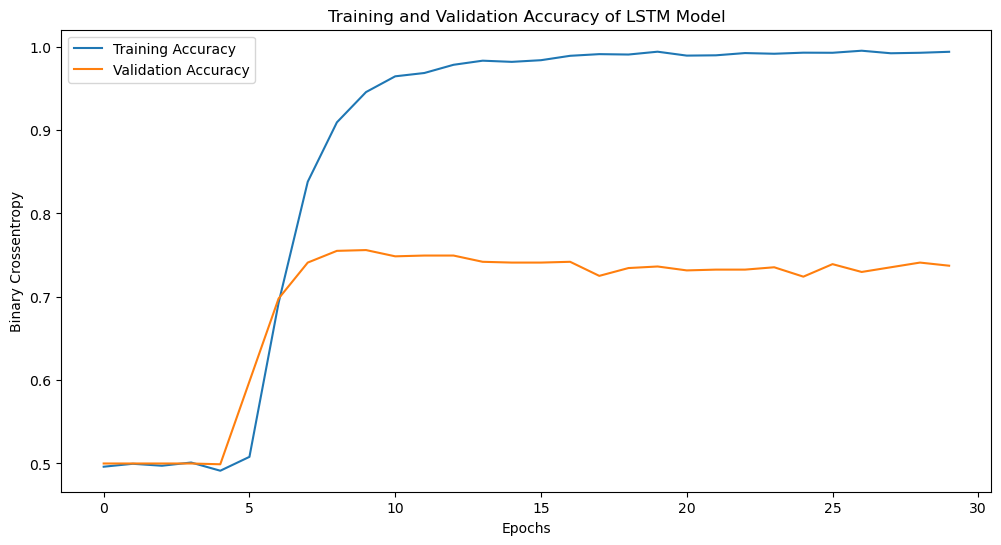

In [105]:
plt.figure(figsize=(12,6))
plt.plot(df_metrics_LSTM_hyperparams.index, df_metrics_LSTM_hyperparams['binary_accuracy'])
plt.plot(df_metrics_LSTM_hyperparams.index, df_metrics_LSTM_hyperparams['val_binary_accuracy'])
plt.title('Training and Validation Accuracy of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [106]:
classifier_test = (model_LSTM_best_model.predict(test_padded) > 0.5).astype('int32')
errorRate_LSTM_hyperparams = (1 - np.round(metrics.accuracy_score(y_test, classifier_test.flatten()), 4))
print("{0: .4%}".format(errorRate_LSTM_hyperparams))

2023-06-10 02:14:31.502158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 02:14:34.333435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 15s 219ms/step
 25.6100%


### LSTM Autoencoder

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
seq_len = 30
def preProcessing (text_arr):
    sequence = tokenizer.texts_to_sequences(text_arr)
    padded = pad_sequences(sequence, maxlen=seq_len, padding='post', truncating='post')
    return sequence, padded

train_sequence, train_padded = preProcessing(x_train)
vali_sequence, vali_padded = preProcessing(x_vali)
test_sequence, test_padded = preProcessing(x_test)

In [20]:
train_padded.shape

(8530, 30)

In [21]:
tensorflow.keras.backend.clear_session()

In [147]:
def LSTM_AE(hp_RT_SA_LSTM_v4):

    hp_units1 = hp_RT_SA_LSTM_v4.Int('units1', min_value=64, max_value=216, step=8)
    hp_units2 = hp_RT_SA_LSTM_v4.Int('units2', min_value=32, max_value=216, step=4)
    hp_units3 = hp_RT_SA_LSTM_v4.Int('units3', min_value=32, max_value=216, step=4)
    hp_units4 = hp_RT_SA_LSTM_v4.Float('units4', min_value=0.2, max_value=0.5, step=0.05)
    hp_units5 = hp_RT_SA_LSTM_v4.Float('units5', min_value=0.2, max_value=0.5, step=0.05)
    hp_units6 = hp_RT_SA_LSTM_v4.Float('units6', min_value=0.6, max_value=0.9, step=0.05)
    
    
    hp_learning_rate = hp_RT_SA_LSTM_v4.Choice('learning_rate', values=[1e-3, 5e-3, 1e-4])
    #hp_l2_regularizer = hp.Choice('l2', values=[L2(1e-2), L2(5e-3), L2(1e-3), L2(5e-4), L2(1e-4)])

    model_SA_LSTM = Sequential()

    model_SA_LSTM.add(Embedding(input_dim = vocabSize, output_dim = hp_units1, input_length = train_padded.shape[1])) #,kernel_regularizer=L2(0.01)
    model_SA_LSTM.add(Dropout(hp_units4))
    model_SA_LSTM.add(LSTM(hp_units2, return_sequences = True))
    model_SA_LSTM.add(Dropout(hp_units5))
    model_SA_LSTM.add(LSTM(hp_units3, return_sequences=False))
    model_SA_LSTM.add(Dropout(hp_units6))
    model_SA_LSTM.add(Dense(1, activation='sigmoid'))
    model_SA_LSTM.compile(loss=BinaryCrossentropy(from_logits=False), 
                    optimizer=Adam(learning_rate = hp_learning_rate), 
                    metrics=[binary_accuracy])
    #model_SA_LSTM.save('../Project/model/RT_SA_LSTM.h5')
    #model_SA_LSTM.summary()
    return model_SA_LSTM

In [149]:
hp_RT_SA_LSTM = keras_tuner.HyperParameters()
LSTM_AE(hp_RT_SA_LSTM)
tuner = keras_tuner.RandomSearch(LSTM_AE, objective = 'val_binary_accuracy', max_trials = 12, executions_per_trial = 1)
tuner.search_space_summary()

Search space summary
Default search space size: 7
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 216, 'step': 8, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 216, 'step': 4, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 216, 'step': 4, 'sampling': None}
units4 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units5 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units6 (Float)
{'default': 0.6, 'conditions': [], 'min_value': 0.6, 'max_value': 0.9, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005, 0.0001], 'ordered': True}


In [150]:
batch = 128
tuner.search(train_padded, y_train, epochs=15, batch_size=batch, validation_data=(vali_padded, y_vali)) #batch_size=batch,

Trial 3 Complete [01h 41m 41s]
val_binary_accuracy: 0.7542213797569275

Best val_binary_accuracy So Far: 0.7542213797569275
Total elapsed time: 03h 24m 47s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |80                |units1
132               |132               |units2
44                |32                |units3
0.45              |0.2               |units4
0.4               |0.25              |units5
0.6               |0.75              |units6
0.005             |0.005             |learning_rate

Epoch 1/15


2023-06-10 08:13:41.385102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:14:04.263796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:14:19.106182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:14:39.467380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:14:52.302171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6598 - binary_accuracy: 0.5837 

2023-06-10 08:27:42.853309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:27:54.628401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 08:27:56.065413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 877s 12s/step - loss: 0.6598 - binary_accuracy: 0.5837 - val_loss: 0.5829 - val_binary_accuracy: 0.7073
Epoch 2/15
67/67 [==============================] - 597s 9s/step - loss: 0.4404 - binary_accuracy: 0.8162 - val_loss: 0.5378 - val_binary_accuracy: 0.7439
Epoch 3/15
67/67 [==============================] - 505s 7s/step - loss: 0.2868 - binary_accuracy: 0.8939 - val_loss: 0.6468 - val_binary_accuracy: 0.7533
Epoch 4/15
67/67 [==============================] - 520s 8s/step - loss: 0.1951 - binary_accuracy: 0.9297 - val_loss: 0.6821 - val_binary_accuracy: 0.7430
Epoch 5/15
67/67 [==============================] - 622s 9s/step - loss: 0.1351 - binary_accuracy: 0.9544 - val_loss: 0.6516 - val_binary_accuracy: 0.7345
Epoch 6/15
67/67 [==============================] - 1266s 19s/step - loss: 0.1206 - binary_accuracy: 0.9624 - val_loss: 0.9420 - val_binary_accuracy: 0.7233
Epoch 7/15
67/67 [==============================] - 1990s 29s/step - loss: 0.0

In [24]:
model_SA_LSTM_hyperparam = Sequential()

model_SA_LSTM_hyperparam.add(Embedding(input_dim = vocabSize, output_dim = 80, input_length = train_padded.shape[1])) #,kernel_regularizer=L2(0.01)
model_SA_LSTM_hyperparam.add(Dropout(0.2))
model_SA_LSTM_hyperparam.add(LSTM(132, return_sequences = True))
model_SA_LSTM_hyperparam.add(Dropout(0.25))
model_SA_LSTM_hyperparam.add(LSTM(32, return_sequences=False))
model_SA_LSTM_hyperparam.add(Dropout(0.75))
model_SA_LSTM_hyperparam.add(Dense(1, activation='sigmoid'))
model_SA_LSTM_hyperparam.compile(loss=BinaryCrossentropy(from_logits=False), 
                optimizer=Adam(learning_rate = 0.005), 
                metrics=[binary_accuracy])
model_SA_LSTM_hyperparam.save('../Project/model/RT_SA_LSTM_hyperparam.h5')
model_SA_LSTM_hyperparam.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 80)            800000    
                                                                 
 dropout_6 (Dropout)         (None, 30, 80)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 132)           112464    
                                                                 
 dropout_7 (Dropout)         (None, 30, 132)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                21120     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
batch = 128
metric = 'val_binary_accuracy'
callback = ModelCheckpoint(filepath=r"../Project/checkpoints/{}".format('RT_SA_LSTM_hyperparams'), monitor=metric,
                    verbose=2, save_best_only=True, mode='max')
history_SA_LSTM_hyperparams = model_SA_LSTM_hyperparam.fit(train_padded, y_train, batch_size=batch, epochs=10, validation_data=(vali_padded, y_vali), callbacks=callback)#validation_data=(x_vali_gen, y_vali_gen)) ,batch_size=batch,

Epoch 1/10


2023-06-10 13:56:07.983450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:08.355949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:08.466830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:08.638704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:08.780669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6480 - binary_accuracy: 0.6127

2023-06-10 13:56:11.717956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:11.837195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-10 13:56:11.895251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.73452, saving model to ../Project/checkpoints/RT_SA_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_SA_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_SA_LSTM_hyperparams/assets


67/67 [==============================] - 8s 91ms/step - loss: 0.6480 - binary_accuracy: 0.6127 - val_loss: 0.5427 - val_binary_accuracy: 0.7345
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.4175 - binary_accuracy: 0.8356
Epoch 2: val_binary_accuracy improved from 0.73452 to 0.75235, saving model to ../Project/checkpoints/RT_SA_LSTM_hyperparams


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_SA_LSTM_hyperparams/assets


INFO:tensorflow:Assets written to: ../Project/checkpoints/RT_SA_LSTM_hyperparams/assets


67/67 [==============================] - 5s 80ms/step - loss: 0.4175 - binary_accuracy: 0.8356 - val_loss: 0.5543 - val_binary_accuracy: 0.7523
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.2572 - binary_accuracy: 0.9103
Epoch 3: val_binary_accuracy did not improve from 0.75235
67/67 [==============================] - 3s 38ms/step - loss: 0.2572 - binary_accuracy: 0.9103 - val_loss: 0.6083 - val_binary_accuracy: 0.7477
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.1777 - binary_accuracy: 0.9428
Epoch 4: val_binary_accuracy did not improve from 0.75235
67/67 [==============================] - 2s 36ms/step - loss: 0.1777 - binary_accuracy: 0.9428 - val_loss: 0.6893 - val_binary_accuracy: 0.7420
Epoch 5/10
67/67 [==============================] - ETA: 0s - loss: 0.1243 - binary_accuracy: 0.9577
Epoch 5: val_binary_accuracy did not improve from 0.75235
67/67 [==============================] - 2s 35ms/step - loss: 0.1243 - binary_accuracy: 0.9

In [26]:
df_metrics_SA_LSTM_hyperparams = pd.DataFrame(history_SA_LSTM_hyperparams.history)
df_metrics_SA_LSTM_hyperparams

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.647973,0.612661,0.542677,0.734522
1,0.417520,0.835639,0.554338,0.752345
2,0.257172,0.910317,0.608287,0.747655
3,0.177728,0.942790,0.689319,0.742026
4,0.124344,0.957679,0.901410,0.747655
5,0.096518,0.968230,0.917368,0.738274
6,0.071885,0.979250,1.224309,0.745779
7,0.052717,0.985111,1.073198,0.741088
8,0.048856,0.986635,1.056856,0.738274
9,0.067284,0.979250,0.959020,0.742026


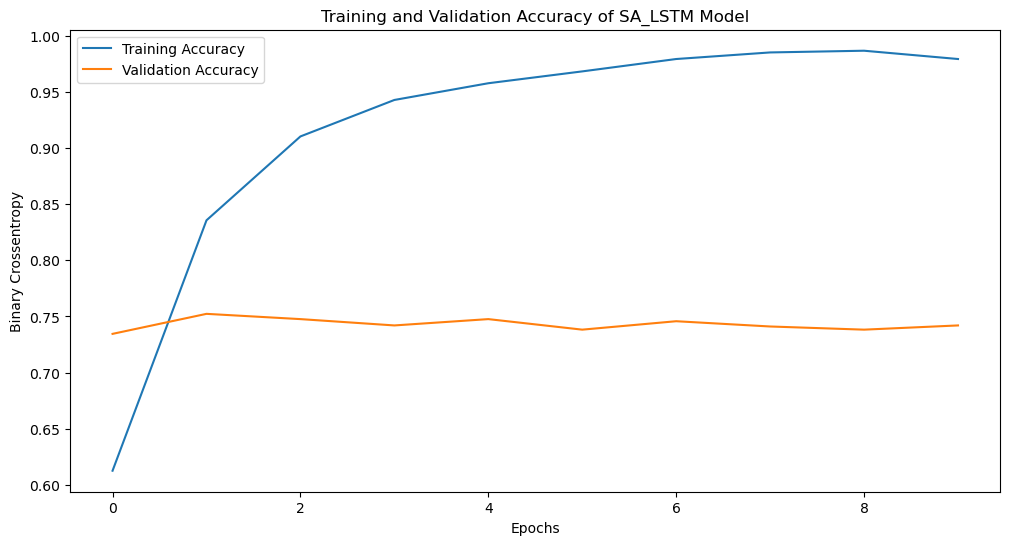

In [27]:
plt.figure(figsize=(12,6))
plt.plot(df_metrics_SA_LSTM_hyperparams.index, df_metrics_SA_LSTM_hyperparams['binary_accuracy'])
plt.plot(df_metrics_SA_LSTM_hyperparams.index, df_metrics_SA_LSTM_hyperparams['val_binary_accuracy'])
plt.title('Training and Validation Accuracy of SA_LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [30]:
classifier_test = (model_SA_LSTM_hyperparam.predict(test_padded) > 0.5).astype('int32')
errorRate_SA_LSTM_hyperparams = (1 - np.round(metrics.accuracy_score(y_test, classifier_test.flatten()), 4))
print("{0: .4%}".format(errorRate_SA_LSTM_hyperparams))

34/34 [==============================] - 0s 11ms/step
 25.8900%
